<a href="https://colab.research.google.com/github/VictorV1ana/churn-prediction/blob/main/Churn_Prediction_for_a_Telecommunications_company_Victor_Viana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, or just *churn*, represents the evasion rate of your customer base. On services like Spotify or Netflix, it represents a subscription cancellation rate.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

It is an important KPI in business that can indicate a problem that should be solved.

*Churn* can be used to predict possible cancelling, and with the right timing it is possible to revert this cenario with reactivation tatatics. This very important because the Costumer Aquisition Cost (CAC) normally is higher than user reactivation.

## Data Acquisition

The data is originally from [IBM developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), and address a typical problem for a telecom company.The complete *dataset*  can be find in [this link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Although there are not explicit data description, the columns names allows us a good understand about the problem.

# Exploratory Data Analysis


### Packages and libraries

In [ ]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# importar pacotes 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc


## DataSet

In [ ]:
# import data 
data_path = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)

In [ ]:
# see first lines 
print('Lines: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))
df.head()

Lines: 7043
Columns: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# create an auxiliar dataframe to analyse missing data 
cons = pd.DataFrame({
                    'type': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unique': df.nunique()})
cons['percentual'] = round(cons['missing'] / cons['size'],2)

In [ ]:
cons

,type,missing,size,unique,percentual
customerID,object,0,7043,7043,0.0
gender,object,0,7043,2,0.0
SeniorCitizen,int64,0,7043,2,0.0
Partner,object,0,7043,2,0.0
Dependents,object,0,7043,2,0.0
tenure,int64,0,7043,73,0.0
PhoneService,object,0,7043,2,0.0
MultipleLines,object,0,7043,3,0.0
InternetService,object,0,7043,3,0.0
OnlineSecurity,object,0,7043,3,0.0


#### Insights
 * There is no missing data in dataset 
 * Most values are objects and binary, which can be a problem for some ml algorithms 
 * `Total charges` probably is not an object - need  feature engenering 
 * `Churn` is the target 
 * `CustumerID` seems not relevant data for ml 

In [ ]:
# selecting inly objects columns
obejct_col = df.select_dtypes(include='object').columns.tolist()

In [ ]:
obejct_col

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [ ]:
# remove columns that are not actually categorical 
obejct_col.remove('customerID')
obejct_col.remove('TotalCharges')

**Categorical  columns Plot**

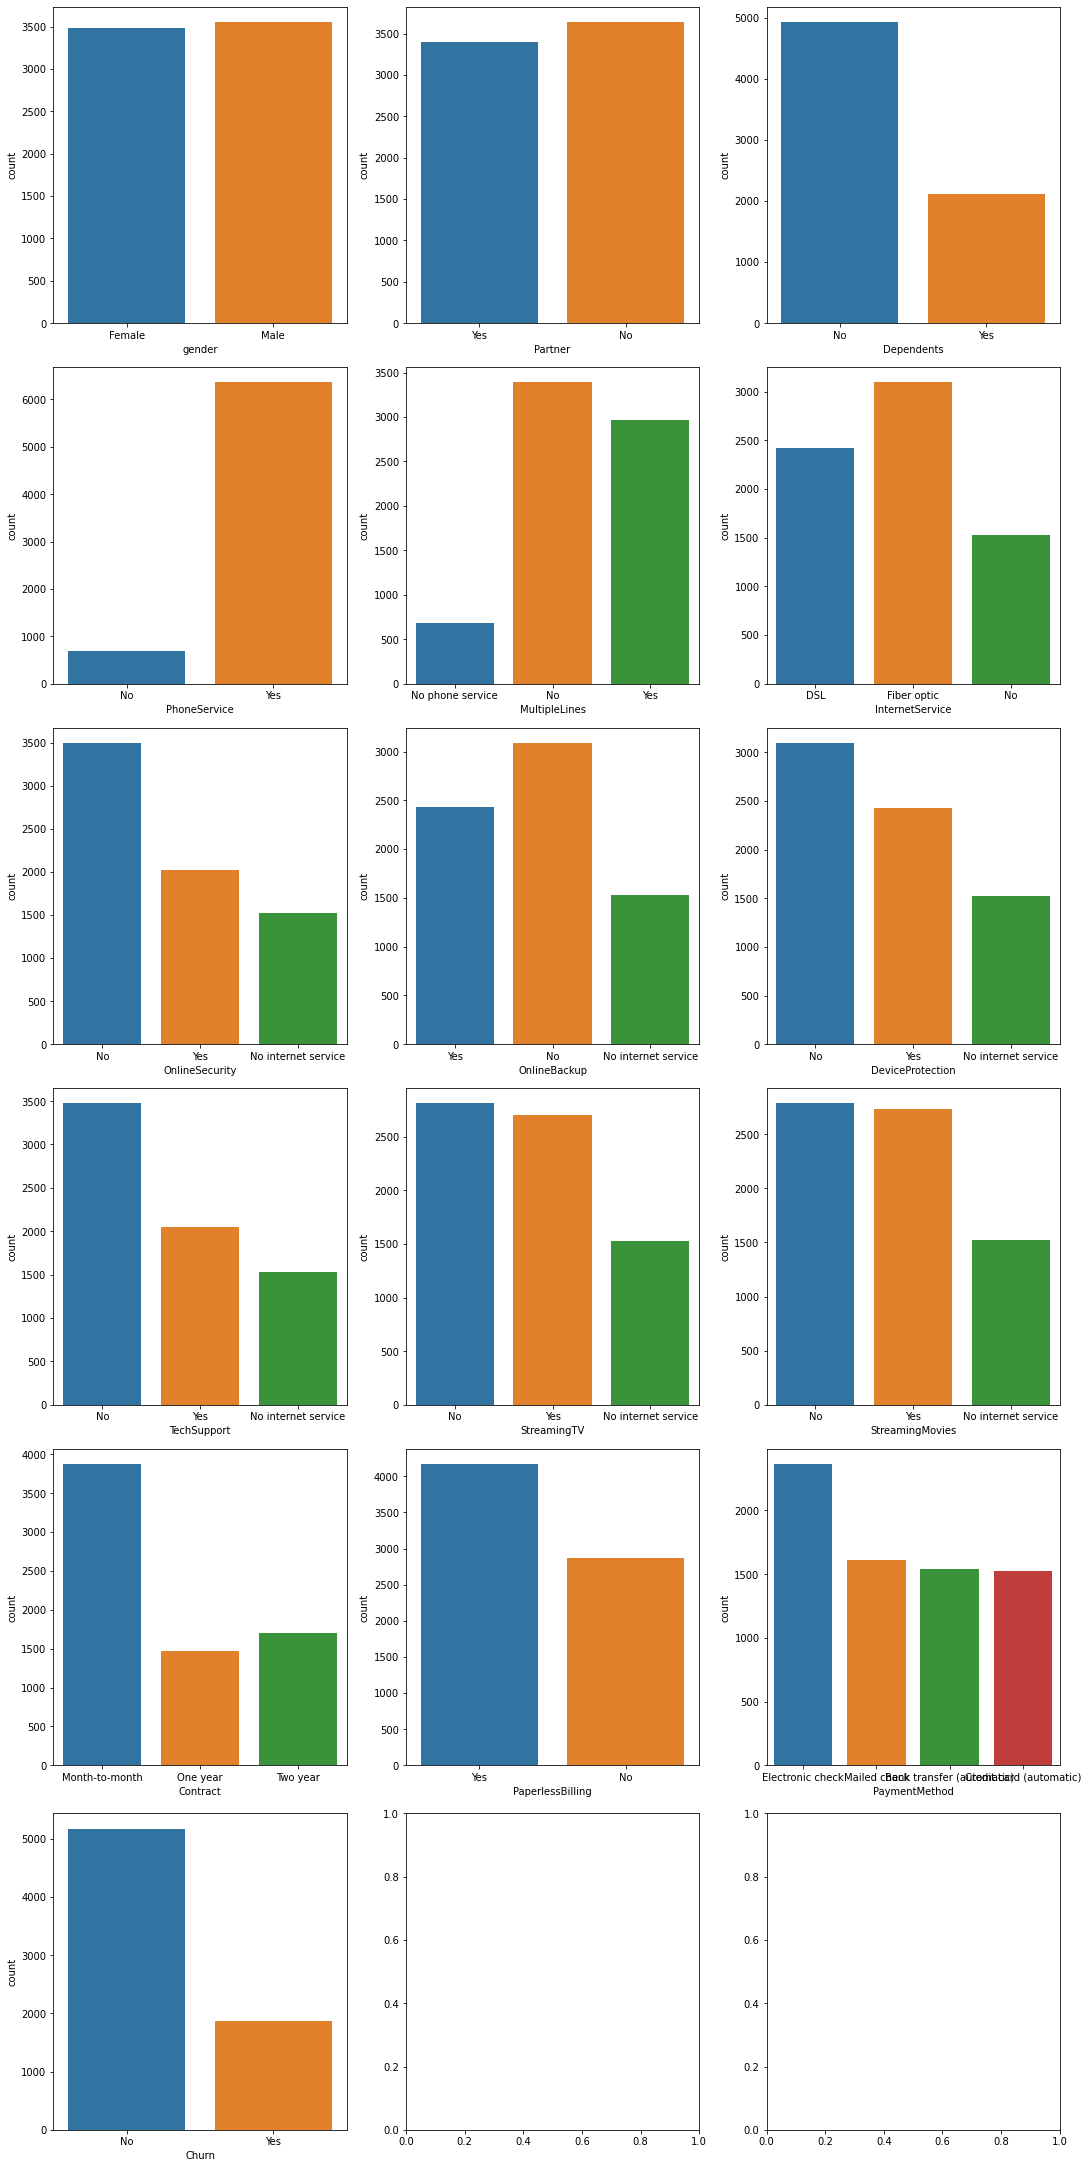

In [ ]:
# plot graph for all categorical columns
num_plots = len(obejct_col)
total_cols = 3 
total_rows = num_plots//total_cols +1 
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,figsize=(5*total_cols, 5*total_rows), constrained_layout=True)

for i, col in enumerate(obejct_col):
  row = i//total_cols
  pos = i% total_cols
  plot = sns.countplot(x = col, data= df,ax=axs[row][pos])

##**Contracts**
**The majority of contracts are month-to-month**

It is easier to cancel a service if you are not in a long term contract, ***the company probably needs to make efforts to get the customers in longer contracts***, to not only avoid churn but also **to have more predictable revenue.**

In [ ]:
# create churn dataset
df_churn= df[df.Churn == "Yes" ]

In [ ]:
# proportion of month-to-month contracts in the general dataset 
contract_general = (df[df.Contract=='Month-to-month'].value_counts().shape[0]/df.shape[0])*100

# proportion of month-to-month contracts for clients that churn  
contract_churn = (df_churn[df_churn.Contract=='Month-to-month'].value_counts().shape[0]/df_churn.shape[0])*100

# proportion of month-to-month contracts for clients that did not churn  
contract_nochurn = (df[(df.Churn=='No') & (df.Contract=='Month-to-month')].shape[0]/df[df.Churn=='No'].shape[0])*100

Porcentage of monthly contracts: 55.02%
Porcentage of monthly contracts of clients that did not churn: 42.91%
Porcentage of monthly contracts of clients that churn: 88.55%


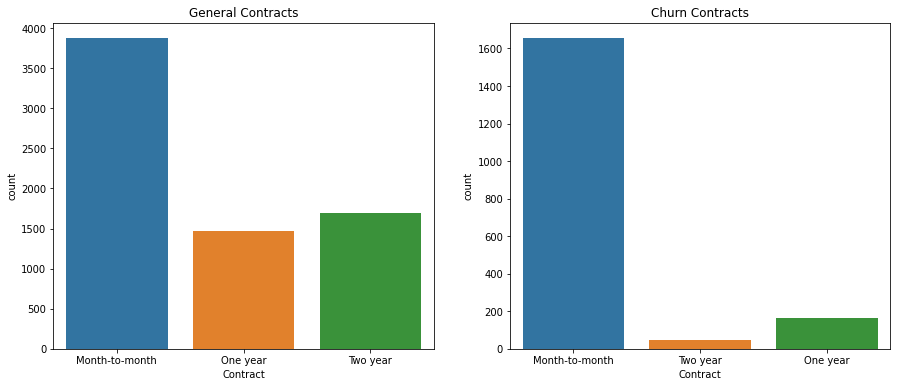

In [ ]:
print('Porcentage of monthly contracts: {:.2f}%'.format(contract_general))
print('Porcentage of monthly contracts of clients that did not churn: {:.2f}%'.format(contract_nochurn))
print('Porcentage of monthly contracts of clients that churn: {:.2f}%'.format(contract_churn))

# graph comparison
fig, (ax1,ax2) = plt.subplots(nrows= 1,ncols=2,figsize=(15,6))
sns.countplot(x="Contract", data =df,ax=ax1)
ax1.set_title("General Contracts")
sns.countplot(x="Contract", data =df_churn,ax=ax2)
ax2.set_title("Churn Contracts")

plt.show()

## Partner

For the company, maybe is ideal to have people who have partners as customers, because if one does not uses but the other does, ***they probably will consider more carefully before cancelling the service.***


* Clients that didnt churn:
  * 52.82% had a partner 
* Clients that **churn:**
  * **Only 35.79% had a partner** 

In [ ]:
# created dataset for no churn 
df_nochurn= df[df.Churn == "No" ]

In [ ]:
# partner proporcion churn 
partner_churn_yes = (df_churn[df_churn.Partner=='Yes'].shape[0]/df_churn.shape[0])*100
partner_churn_no = (df_churn[df_churn.Partner=='No'].shape[0]/df_churn.shape[0])*100

# partner proporcion no churn 
partner_nochurn_yes = (df_nochurn[df_nochurn.Partner=='Yes'].shape[0]/df_nochurn.shape[0])*100
partner_nochurn_no = (df_nochurn[df_nochurn.Partner=='No'].shape[0]/df_nochurn.shape[0])*100

# print results
print('Clients that didnt churn:\n {:.2f}% had a partner and {:.2f} did not\nClients that churn:\n {:.2f}% had a partner and {:.2f} did not'.format(partner_nochurn_yes,partner_nochurn_no,partner_churn_yes,partner_churn_no))

Clients that didnt churn:
 52.82% had a partner and 47.18 did not
Clients that churn:
 35.79% had a partner and 64.21 did not


## Dependents
**The majority does not have a dependent** - which can lead to the same hypotheses cited before 

* Clients that **didnt churn**:
 * **34.48%** had dependents 
* Clients that **churn**:
 * **17.44%** had dependents

In [ ]:
# partner proporcion no churn 
dependent_nochurn_yes = (df_nochurn[df_nochurn.Dependents=='Yes'].shape[0]/df_nochurn.shape[0])*100
dependent_nochurn_no = (df_nochurn[df_nochurn.Dependents=='No'].shape[0]/df_nochurn.shape[0])*100

# partner proporcion churn 
dependent_churn_yes = (df_churn[df_churn.Dependents=='Yes'].shape[0]/df_churn.shape[0])*100
dependent_churn_no = (df_churn[df_churn.Dependents=='No'].shape[0]/df_churn.shape[0])*100

# print results
print('Clients that didnt churn:\n {:.2f}% had dependents and {:.2f} did not\nClients that churn:\n {:.2f}% had dependents and {:.2f} did not'.format(dependent_nochurn_yes,dependent_nochurn_no,dependent_churn_yes,dependent_churn_no))

Clients that didnt churn:
 34.48% had dependents and 65.52 did not
Clients that churn:
 17.44% had dependents and 82.56 did not


* **Churn customers had far fewer dependents than those who stayed with the service**

## Payment Method
**Mailed check is the second favourite payment method** -

If there is a high churn caused by customers that did not pay, **the company needs to make in strategy to up the numbers of automatic payment method**. Nowadays a lot of bailing is done online, maybe they forgot to pay but did not want to cancel the service. Besides that, **it *gives fewer chances to the customer to consider if he/she really wants to cancel*.**

* Clients that **didnt churn**:
 * **49.79%** automatic payment 
* Clients that **churn**
 * **26.22%** automatic payment

In [ ]:
# partner proporcion churn 
payment_churn_mail = (df_churn[(df_churn.PaymentMethod =='Mailed check') |(df_churn.PaymentMethod =='Electronic check')].shape[0]/df_churn.shape[0])*100
payment_churn_nomail = (df_churn[(df_churn.PaymentMethod =='Credit card (automatic)') |(df_churn.PaymentMethod =='Bank transfer (automatic)')].shape[0]/df_churn.shape[0])*100

# partner proporcion no churn 
payment_nochurn_mail = (df_nochurn[(df_nochurn.PaymentMethod =='Mailed check') |(df_nochurn.PaymentMethod =='Electronic check')].shape[0]/df_nochurn.shape[0])*100
payment_nochurn_nomail = (df_nochurn[(df_nochurn.PaymentMethod =='Credit card (automatic)') |(df_nochurn.PaymentMethod =='Bank transfer (automatic)')].shape[0]/df_nochurn.shape[0])*100

# print results
print('Clients that didnt churn:\n {:.2f}% Mail {:.2f}% automatic\nClients that churn:\n {:.2f}% Mail and {:.2f}% automatic'.format(payment_nochurn_mail,payment_nochurn_nomail,payment_churn_mail,payment_churn_nomail))

Clients that didnt churn:
 50.21% Mail 49.79% automatic
Clients that churn:
 73.78% Mail and 26.22% automatic


* **Clients that churn had far less automatic payment methods**

## Cleaning up the dataset

Some labels have the same meaning so there is no reason to have multible labels.

In [ ]:
df_clean = df.copy()

In [ ]:
# replace 'no service' for 'no'
df_clean.replace(['No internet service','No phone service'],'No', inplace=True)

# consider credit card and bank transfer 'automatic'
df_clean.replace(['Bank transfer (automatic)','Credit card (automatic)'],'Automatic', inplace= True)

## Analyzing Numerical Data

In [ ]:
#df["TotalCharges"].astype('float32')
  #could not convert string to float:

In [ ]:
def convert_str_float(column):
  try:
    return float(column)
  except ValueError:
    return np.nan

In [ ]:
# apply function to transform data to numerical
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(convert_str_float)
print('Total Charges nan values: {}'.format(df_clean['TotalCharges'].isnull().sum()))

Total Charges nan values: 11


In [ ]:
# change nan values to the median 
df_clean["TotalCharges"].fillna(df_clean.TotalCharges.median(), inplace=True)

#exclude custumerID
df_clean.drop('customerID',axis=1,inplace=True)

In [ ]:
num_col = df_clean.select_dtypes(exclude='object').columns.tolist()
num_col

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
# statistical facts 
df_clean.describe() 

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


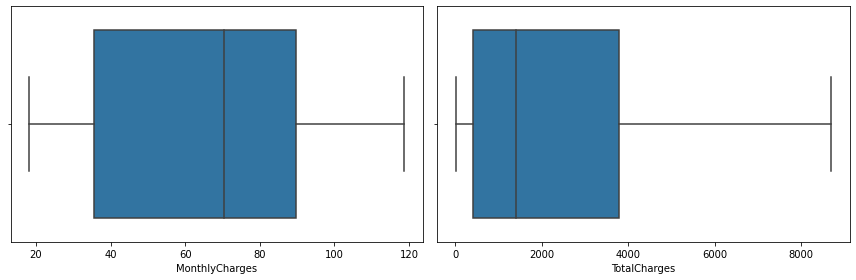

In [ ]:
# boxplot for Monthly Charges and Total Charges
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

Neither the `describe()` nor the boxplot indicates that we have outliers.    

Although, `Total Charges` has a positive skewness

Skewness:0.9637890936414893


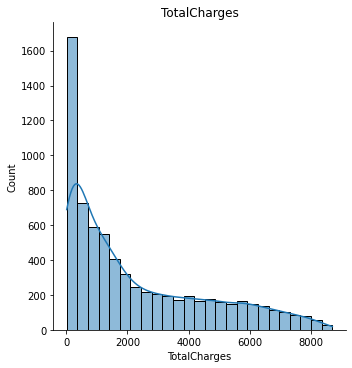

In [ ]:
print('Skewness:{}'.format(df_clean["TotalCharges"].skew() ))
sns.displot(data=df_clean, x="TotalCharges", kde=True)
plt.title('TotalCharges')
plt.show()

Skewness:-0.22052443394398033


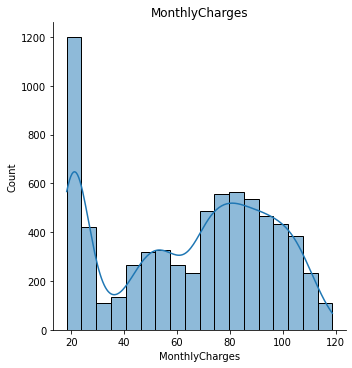

In [ ]:
print('Skewness:{}'.format(df_clean["MonthlyCharges"].skew() ))
sns.displot(data=df_clean, x="MonthlyCharges", kde=True)
plt.title('MonthlyCharges')
plt.show()

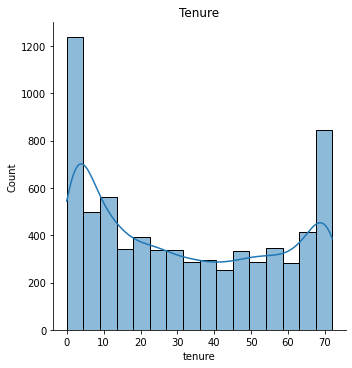

In [ ]:
# tenure displot
sns.displot(data=df_clean, x="tenure", kde=True)
plt.title('Tenure')
plt.show()

**Bimodal or multimodal distribution**
* The customers tend to peak in the extremes 

**In a different context this distribution can inform different scenarios, some are:**
* High Customer acquisition but low retention 
* Now the company is investing in user acquisition and in the future, they will be part of that 'uniform distribution' in the middle.

## Pre Processing

In [ ]:
# pre processing variables 
# select binary varibles 
bi_var = df_clean.nunique()[df_clean.nunique() ==  2].keys().tolist()

#select numeriacal but not binary varibles
num_var = [col for col in df_clean.select_dtypes(['int','float']).columns.tolist() if col not in bi_var]

# categorical vut not binary or numeric  
cat_var = [col for col in df_clean.columns.tolist() if col not in bi_var + num_var]

# create pre processing dataframe 
df_prep = df_clean.copy()

# Label Encoding for binary varibles
le = LabelEncoder()
for i in bi_var:
    df_prep[i] = le.fit_transform(df_prep[i])

In [ ]:
# Encoding categorical columns with multiple classes
df_prep = pd.get_dummies(df_prep, columns=cat_var)

# first 5 of the new dataset
df_prep.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Automatic,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,1,0


## Machine Learning

In [ ]:
# split target from X 
X = df_prep.drop('Churn', axis =1)
y = df_prep['Churn']

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
def val_model(X, y, model, quite=False):
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), model)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

**Create Baseline model**

The idea is to create a model without any type of transformation in the dataset or hyperparameter tuning, so we can really evaluate if our pre-processing and parameter tunning is worth it.

In [ ]:
# create base line and print result
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.49 (+/- 0.02)


**Standardization and Under-Sampling**

Now we will standardize our data and use and undersampling, because as we detected before the dataset is imbalanced. To better the results of the Machine Learning algorithm, I will a random under-sampler. I choose not to use oversampling, with SMOTE for example, based on this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.477.1151&rep=rep1&type=pdf).

In [ ]:
# standardize data 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# under-sampling data
ru = RandomUnderSampler()
X_train_ru, y_train_ru = ru.fit_sample(X_train,y_train)

**How different models perform this task?**

I have selected some models based on similar problems performed well, and then choose two to work with.

In [ ]:
# instantiate models 
np.random.seed(42)
rf = RandomForestClassifier()
svc = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()

In [ ]:
recall=[]
clf=[]

# create dataframe with test results from the models selected 
for model in (rf, dt, svc, lr):
    clf.append(model.__class__.__name__)
    recall.append(val_model(X_train_ru, y_train_ru, model, quite=True))

pd.DataFrame(data=recall, index=clf, columns=['Recall'])

,Recall
RandomForestClassifier,0.767626
DecisionTreeClassifier,0.684173
SVC,0.783453
LogisticRegression,0.802158


**SVC and Logistic Regression** had a better performance, so I will try to look for better parameters and increase our model performance.

### **Hyperparmter Optimazition**

#### **Logistic Regression** 

After selecting some possible values for the logistic regression model, I am going run `GridSearchCV` which will try all the possibles combinations and give the best one so we can use it.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid=[{
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4,4,20),
    'solver' : ['lbfgs', 'newton-cg', 'libkinear', 'sag', 'saga'],
    'max_iter':[100,1000,2500,5000]
    }
]
lg_clf = GridSearchCV(LogisticRegression(),param_grid = param_grid,cv=5, return_train_score=False,scoring='recall')
lg_clf.fit(X_train_ru,y_train_ru)
lg_results = pd.DataFrame(lg_clf.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got libkinear.

  FitFailedWarning)
/usr/loc

KeyboardInterrupt: ignored

**Best Parmiters Data Set for Logistic Regression**

In [ ]:
# drop combinations that were not possible 
lg_results.dropna(axis=0, inplace = True)
# only show the top 15 models
lg_results['rank_test_score']= lg_results['rank_test_score'].astype('int')
lg_results[lg_results['rank_test_score'] <= 15]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
44,0.003446,0.000047,0.001537,0.000043,0.0001,2500,l1,saga,"{'C': 0.0001, 'max_iter': 2500, 'penalty': 'l1...",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
64,0.003635,0.000058,0.001628,0.000039,0.0001,5000,l1,saga,"{'C': 0.0001, 'max_iter': 5000, 'penalty': 'l1...",1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,10
144,0.003466,0.000020,0.001623,0.000189,0.000263665,5000,l1,saga,"{'C': 0.00026366508987303583, 'max_iter': 5000...",1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,10
264,0.013162,0.002637,0.001895,0.000186,0.00183298,1000,l1,saga,"{'C': 0.0018329807108324356, 'max_iter': 1000,...",1.000000,1.000000,0.000000,1.000000,1.000000,0.800000,0.400000,10
324,0.027463,0.001285,0.001764,0.000036,0.00483293,100,l1,saga,"{'C': 0.004832930238571752, 'max_iter': 100, '...",0.910072,0.848921,0.834532,0.845324,0.863309,0.860432,0.026472,2
344,0.033809,0.005159,0.001892,0.000148,0.00483293,1000,l1,saga,"{'C': 0.004832930238571752, 'max_iter': 1000, ...",0.910072,0.848921,0.834532,0.845324,0.863309,0.860432,0.026472,2
364,0.029183,0.002124,0.001803,0.000054,0.00483293,2500,l1,saga,"{'C': 0.004832930238571752, 'max_iter': 2500, ...",0.910072,0.848921,0.834532,0.845324,0.863309,0.860432,0.026472,2
384,0.030024,0.001856,0.001774,0.000034,0.00483293,5000,l1,saga,"{'C': 0.004832930238571752, 'max_iter': 5000, ...",0.910072,0.848921,0.834532,0.845324,0.863309,0.860432,0.026472,2
404,0.035549,0.004023,0.002017,0.000289,0.0127427,100,l1,saga,"{'C': 0.012742749857031334, 'max_iter': 100, '...",0.859712,0.784173,0.794964,0.787770,0.784173,0.802158,0.029046,6
424,0.037127,0.005054,0.002116,0.000208,0.0127427,1000,l1,saga,"{'C': 0.012742749857031334, 'max_iter': 1000, ...",0.859712,0.784173,0.794964,0.787770,0.784173,0.802158,0.029046,6


Since the best model clearly overfited, the chosen parmiters is the second in `rank_test_score` 

`C = 0.00483293, max_iter = 100, penalty = 'l1',solver = 'saga'`

#### **SVC** 
For the svc model, I am going to use the same flow, but to save computational power a different technique will be used `RandomizedSearchCV` - it will search for the best combination but randomly selecting the combinations and applying cross-validation to select the best one. 

*for more in-depth explanation visit documentation*

In [ ]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
svc_clf = RandomizedSearchCV(svm.SVC(gamma='auto'), {
    'C': [100, 10,20, 1.0, 0.1, 0.001],
    'kernel': ['rbf','linear', 'poly','sigmoid']
}, cv=5, return_train_score=False, scoring = 'recall',n_iter=15)
svc_clf.fit(X_train_ru, y_train_ru)
svc_clf.cv_results_

{'mean_fit_time': array([0.17064075, 0.15805688, 0.25767345, 0.23452826, 0.31586757,
        0.83903718, 0.23298087, 0.37465768, 0.2457747 , 0.34441853,
        0.52600756, 0.25142002, 0.23254094, 0.39010844, 0.35143914]),
 'mean_score_time': array([0.03111548, 0.02992897, 0.02185769, 0.04094009, 0.04066172,
        0.02132215, 0.04053764, 0.04115481, 0.0380774 , 0.07020946,
        0.03859315, 0.05165324, 0.04547286, 0.0872745 , 0.02144527]),
 'mean_test_score': array([0.6647482 , 0.67194245, 0.7381295 , 0.78273381, 0.74676259,
        0.82517986, 0.97482014, 0.73165468, 0.71582734, 0.71151079,
        0.69928058, 0.83669065, 0.80215827, 0.85683453, 0.71870504]),
 'param_C': masked_array(data=[20, 100, 10, 1.0, 10, 10, 0.001, 20, 1.0, 0.001, 100,
                    0.1, 0.1, 0.001, 20],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 '

**Best paramiters dataset**

In [ ]:
#get results and tranform into a dataset 
pd.DataFrame(svc_clf.cv_results_)[['param_C','param_kernel','mean_test_score']]


,param_C,param_kernel,mean_test_score
0,20,sigmoid,0.664748
1,100,sigmoid,0.671942
2,10,poly,0.738129
3,1,rbf,0.782734
4,10,rbf,0.746763
5,10,linear,0.825180
6,0.001,poly,0.974820
7,20,rbf,0.731655
8,1,sigmoid,0.715827
9,0.001,rbf,0.711511


In [ ]:
# best score
svc_clf.best_score_

0.9748201438848921

In [ ]:
# best paramiters
svc_clf.best_params_

{'C': 0.001, 'kernel': 'poly'}

#### Test Models 
Now we are going to test the models and analyze which is the best choice. For the model evaluation, the most important metric is **Recall** because we p**rioritize classifying churn cases correctly** much better than having good accuracy. However, it is important to note that metrics such as **accuracy and AUC will also be evaluated** because a model that hits churn cases a lot and is also generalist is "the ideal" model.

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1282
           1       0.62      0.44      0.52       479

    accuracy                           0.77      1761
   macro avg       0.72      0.67      0.68      1761
weighted avg       0.76      0.77      0.76      1761

AUC: 0.6706



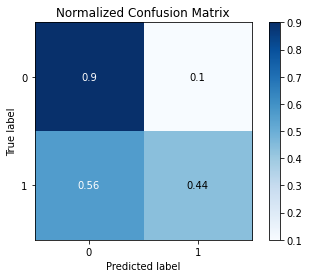

In [ ]:
# final model 
model = LogisticRegression(C = 0.00483293, max_iter = 100, penalty = 'l1',solver = 'saga')
model.fit(X_train_ru,y_train_ru)
# scale test data set 
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# Classification report 
print(classification_report(y_test,y_pred))
# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

The Logistic Regression, could not perform well with the hyperparameter optimization, prioritizing no-churn cases. It has better performance than the others but does not deliver the expected results in other metrics 

              precision    recall  f1-score   support

           0       0.94      0.49      0.65      1282
           1       0.40      0.91      0.56       479

    accuracy                           0.61      1761
   macro avg       0.67      0.70      0.60      1761
weighted avg       0.79      0.61      0.62      1761

AUC: 0.7041



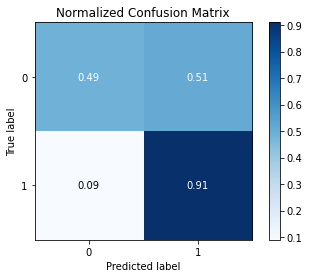

In [ ]:
# final model 
model = svm.SVC(C= 0.001, kernel = 'poly')
model.fit(X_train_ru,y_train_ru)
# scale test data set 
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# Classification report 
print(classification_report(y_test,y_pred))
# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

This is a really good model if the company will not spend money trying to reactivate the client. Since it has dificulties classifing the cases that did not occurer churn and it is very good at predicting churn cases.

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1282
           1       0.47      0.87      0.61       479

    accuracy                           0.70      1761
   macro avg       0.70      0.75      0.69      1761
weighted avg       0.80      0.70      0.72      1761

AUC: 0.7538



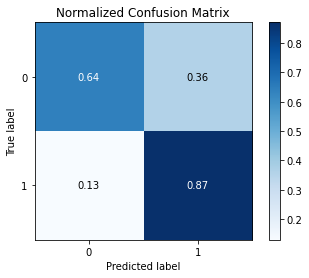

In [ ]:
# final model 
model = svm.SVC(C= 0.001, kernel = 'sigmoid')
model.fit(X_train_ru,y_train_ru)
# scale test data set 
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# Classification report 
print(classification_report(y_test,y_pred))
# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

If we analyze only the recall concerning churn this model performs worst than the previous. But it is a small difference of .04 that is compensated by the increase in accuracy(0.09) and AUC(0.05) and the recall for not churn cases.

In summary, this model has better performance because it is not only able to predict churn cases but can also have a decent performance in not churn cases. This very important because, **reactivating a client if not cost money at least cost time, *and avoid time and money waste is a huge priority for any company*.**

## Conclusion 
In this mini-project, we were able to collect and analyze the data creating business insights that are really valuable to the Telecom Company:
* **Month-to-Month contracts are not ideal if we want to avoid churn** 
* **Clients that have some sort of partnership tend to  churn less** or at least having a balanced customer base is better - since clients that stayed had a proportion of 50/50
* **The more dependents, the better** - clients that stayed with the service had a larger proportion of dependents 
* **73.78% of the clients did not have automatic payment** - so changing this proportion **can be an action plan to reduce churn.**

***And the same analysis can be done by any firm that has the same business model and Saas.*** 

Last but not least, **we created a model that can predict churns** **and it also avoids revenue and time waste because it can generalize.** *In my view there is still room for improvement of the model, so share with me your approaches.* 

*Any suggestions or critics please contact me via e-mail I am looking forward to improving my skills.*

*If there are any English mistakes I am sorry but it is not my first language, I am looking forward to having a better understanding of it so I can communicate better my ideas. :)*